In [158]:
import sklearn
import hdbscan
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import time

from scipy.io import arff
from sklearn.cluster import DBSCAN
from sklearn.cluster import KMeans
from sklearn.cluster import AgglomerativeClustering
from mpl_toolkits import mplot3d
from sklearn import metrics

In [2]:
data1 = arff.loadarff(open('datasets/artificial/R15.arff','r'))
data2 = arff.loadarff(open('datasets/artificial/diamond9.arff','r'))
data3 = arff.loadarff(open('datasets/artificial/spherical_4_3.arff','r')) 

#Datasets for agglomerative clustering
data4 = arff.loadarff(open('datasets/artificial/zelnik3.arff','r'))
data5 = arff.loadarff(open('datasets/artificial/complex9.arff','r')) 
data6 = arff.loadarff(open('datasets/artificial/banana.arff','r'))

#Datasets for DBSCAN
data7 = arff.loadarff(open('datasets/artificial/zelnik2.arff','r'))
data8 = arff.loadarff(open('datasets/artificial/zelnik4.arff','r'))
data9 = arff.loadarff(open('datasets/artificial/cure-t2-4k.arff','r'))

#Comparison between HDB and DBSCAN
data10 = arff.loadarff(open('datasets/artificial/st900.arff','r'))
data11 = arff.loadarff(open('datasets/artificial/2sp2glob.arff','r'))
data12 = arff.loadarff(open('datasets/artificial/donut3.arff','r'))


In [179]:


#Definition des fonctions

"""La fonction ci-dessous nous permet de récupérer les bons noms de colonnes des dataframe
car leurs noms peut changer entre les différents dataset"""

def init_df_cluster(df):
    return df[df.columns[0]], df[df.columns[1]] 

"""La fonction ci-dessous implémente la méthode des kmeans, pour une nombre maximum de 
cluster étant égal à max_clusters. La méthode retourne ensuite la valeur optimale de nombre de cluster
calculée par KMeans"""

def Kmeans(dataset, max_clusters = 20):
    
    list_kmeans, list_scores = [], []
    
    for i in range(2,max_clusters+1):
        kmeans = KMeans(n_clusters = i, random_state=0).fit(dataset)
        list_kmeans.append(kmeans)
        list_scores.append(sklearn.metrics.silhouette_score(dataset, kmeans.labels_))
    
    max_value = max(list_scores)
    return list_kmeans[list_scores.index(max_value)]


"""La fonction des kmeans ci-dessous propose une option permettant de s'arrêter lorsque l'amélioration
de l'inertie des clusters est inférieure à un certain pourcentage donné en paramètre. Par exemple, 
si l'inertie passe de 200 à 192, la fonction va retourner la clusterisation avec l'inertie de 192"""

def Kmeans_inertia(dataset, max_clusters = 20, pourcentage = 0.05):
    
    list_kmeans, list_scores, list_time = [], [], []
    
    for i in range(1,max_clusters):
        timer = time.time()
        kmeans = KMeans(n_clusters = i, random_state=0).fit(dataset)
        list_kmeans.append(kmeans)
        list_scores.append(kmeans.inertia_)
        list_time.append(round(time.time() - timer,4))

    best_cluster_number = len(list_scores)
    #plt.figure()
    #plt.plot(np.linspace(1,max_clusters - 1,max_clusters - 1), list_time)
    #plt.show()
    #print(list_time)

    for i in range(1, len(list_scores)):
        ecart = list_scores[i - 1] - list_scores[i] 
        if (ecart < list_scores[i - 1] * pourcentage):
            break
    return (list_kmeans[i-1])

"""La fonction ci-dessous implémente la méthode de clustering agglomératif, avec une option 'show_time'
permettant de plot le temps d'exécution en fonction du nombre de cluster choisi.
En abscisse, le nombre de cluster; en ordonnée, le temps de ms"""

def agglomerative(dataset, max_clusters = 20, show_time = False):
    
    time_list = [] 
    list_X, list_scores = [], []
    
    for i in range(2,max_clusters):
        timer = time.time()
        clusters = AgglomerativeClustering(n_clusters=i).fit(dataset)
        list_X.append(clusters)
        list_scores.append(sklearn.metrics.silhouette_score(dataset,clusters.labels_))
        max_value = max(list_scores)       
        time_list.append(time.time() - timer)
               
    if(show_time):
        plt.figure()
        plt.plot(np.linspace(1,max_clusters - 2,max_clusters - 2), time_list)
        plt.show()
    return list_X[list_scores.index(max_value)]

"""Cette fonction permet de plotter les clusters calculés par la méthode agglomerative sur un dataset 
donné"""

def plot_agglomerative(dataset, time = False): 
    dataset = process_name(dataset)
    solution = agglomerative(dataset, show_time = time)

    X, Y = init_df_cluster(dataset)
    plt.figure()
    plt.scatter(X, Y, c = solution.labels_)
    plt.legend()
    plt.show()
    
def plot_clusters_kmeans(dataset):
    dataset = process_name(dataset)
    solution = Kmeans(dataset)

    X, Y = init_df_cluster(dataset)
    print(solution)
    plt.scatter(X, Y, c = solution.labels_)
    plt.scatter(solution.cluster_centers_[:,0], solution.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    
def plot_clusters_kmeans_inertia(dataset):
    data = process_name(dataset)
    solution = Kmeans_inertia(data)
    X, Y = init_df_cluster(data)
    plt.figure()
    plt.scatter(X, Y, c = solution.labels_)
    plt.scatter(solution.cluster_centers_[:,0], solution.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    plt.show()

#VERSION MISTERY

def plot_clusters_kmeans3D(dataset):
    dataset = process_name(dataset)
    clusters = Kmeans(dataset)
    X, Y = init_df_cluster(dataset)
    fig = plt.figure()
    ax = plt.axes(projection ='3d')
    ax.scatter(dataset.iloc[:,0], dataset.iloc[:,1], dataset.iloc[:,2], c = clusters.labels_)
    #plt.scatter(nom.cluster_centers_[:,0], nom.cluster_centers_[:,1], nom.cluster_centers_[:,2], c='r', label = 'centers')
    #plt.scatter(X, Y, c = nom.labels_)
    #plt.scatter(nom.cluster_centers_[:,0], nom.cluster_centers_[:,1], c='r', label = 'centers')
    plt.legend()
    plt.show()
    
def plot_dbscan(dataset, eps_param = 0.5, min_samples_param = 10):
    dataset = process_name(dataset)
    DBSCAN_result = DBSCAN(eps = eps_param, min_samples = min_samples_param).fit(dataset)
    X, Y = init_df_cluster(dataset)
    plt.scatter(X,Y, c = DBSCAN_result.labels_)
    
def plot_dbscan_iteration(dataset):
    list_scores = []
    dataset = process_name(dataset)
    X, Y = init_df_cluster(dataset)
    eps_list = np.linspace(0.1, 1, 10)
    for eps in eps_list:
        for samples in range(2,6):
            time_start = time.time()
            DBSCAN_result = DBSCAN(eps = eps, min_samples = samples).fit(dataset)
            plt.figure()
            plt.scatter(X,Y, c = DBSCAN_result.labels_)
            plt.xlabel(f"eps = {eps}, le nombre de samples est de {samples}") 
            plt.legend()
            plt.show()
            print(f"Le temps d'exécution est de : {time.time() - time_start}")
            #print(DBSCAN_result.labels_)
            #print(metrics.silhouette_score(DBSCAN_result, DBSCAN_result.labels_)) <- voir bug

    
def plot_hdbscan(dataset, min_cluster_size = 10):
    dataset = process_name(dataset)
    
    X, Y = init_df_cluster(dataset)
    
    clusterer = hdbscan.HDBSCAN(min_cluster_size)
    clusterer_labels = clusterer.fit_predict(dataset)
    
    plt.figure()
    plt.scatter(X, Y, c = clusterer_labels)


C:\Users\xSyl0\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1038: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


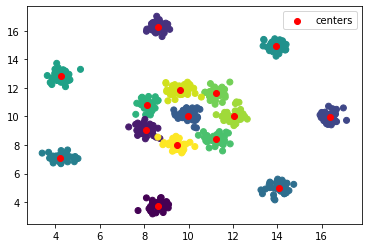

In [160]:
def process_name(dataset):
    df = pd.DataFrame(dataset[0])
    list_name = df.iloc[:, -1]
    list_pre, list_post, compteur = [], [], 0
    for element in list_name:
        if element not in list_pre:
            list_pre.append(element)
            list_post.append(compteur)
            compteur+=1
    for i in range(len(list_pre)):
        df.iloc[:, -1] = list_name.replace(list_pre[i], list_post[i])
    return df
    
    
    
plot_clusters_kmeans_inertia(data1)

In [ ]:
data = data1
df = pd.DataFrame(data[0])
X, Y = df['x'], df['y']

X2, Y2 = [], []
liste = []

j = 20

for i in range(1,j):
    kmeans = KMeans(n_clusters = i, random_state=0).fit(df)
    X2.append(i)
    Y2.append(kmeans.inertia_)
    liste.append(kmeans)
    
pourcentage = 0.05
best_cluster_number = len(Y2)

for i in range(1, len(Y2)):
    ecart = Y2[i - 1] - Y2[i] 
    if (ecart < Y2[i - 1] * pourcentage):
        best_cluster_number = i
        break
        

plt.figure()
plt.plot(X2, Y2)

kmeans = KMeans(n_clusters = best_cluster_number, random_state=0).fit(df)
plt.figure()
plt.scatter(X, Y, c = kmeans.labels_)
plt.scatter(kmeans.cluster_centers_[:,0], kmeans.cluster_centers_[:,1], c='r')

In [ ]:
time_tab = []

time_start = time.time()
n = 20

for i in range(1,n):
    time_start = time.time()
    kmeans = KMeans(n_clusters = i, random_state=0).fit(df)
    X1.append(i)
    Y1.append(kmeans.inertia_)
    time_end = time.time()
    time_exec = time_end - time_start
    time_tab.append(time_exec)
    
print(time_tab)
    
X = np.linspace(1,n - 1,n - 1)
plt.figure()
plt.plot(X, time_tab)

In [ ]:
df = pd.DataFrame(data4[0])
X1, Y1 = [], []
X3, Y3 = df['x'], df['y']

list_clusters = []
time_tab = []

for i in range(2,n):
    time_start = time.time()
    clusters = AgglomerativeClustering(n_clusters=i).fit(df)
    list_clusters.append(clusters)
    score = sklearn.metrics.silhouette_score(df,clusters.labels_)
    X1.append(i)
    Y1.append(score)
    
    time_end = time.time()
    time_exec = time_end - time_start
    time_tab.append(time_exec)

best_score = max(Y1)
index_best_score = Y1.index(best_score)

print(f"Le nombre de cluster optimal est {index_best_score + 2}")
print(best_score)

plt.figure()
plt.scatter(X3, Y3, c = list_clusters[index_best_score].labels_)
plt.show()

X = np.linspace(1,n - 2,n - 2)
plt.figure()
plt.plot(X, time_tab)

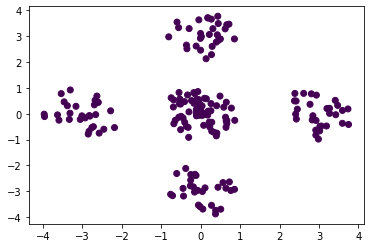

In [76]:
# DBSCAN
df = process_name(data7)
X4, Y4 = init_df_cluster(df)

DBSCAN_result = DBSCAN(eps = 1, min_samples = 10).fit(df)
plt.scatter(X4,Y4, c = DBSCAN_result.labels_)

In [ ]:
df = process_name(data7)
X5, Y5 = init_df_cluster(df)

df["class"] = df["class"].replace(b'noise', b'10')

clusterer = hdbscan.HDBSCAN(min_cluster_size=10)
clusterer_labels = clusterer.fit_predict(df)


#plt.figure()
#plt.scatter(X4, Y4, c = DBSCAN_result.labels_)

In [23]:
#Dataset du monde réel
data_real1 = arff.loadarff(open('datasets/real-world/iris.arff','r'))
data_real2 = arff.loadarff(open('datasets/real-world/balance-scale.arff','r'))

In [21]:
colnames = ['X', 'Y', 'Z']

mystery_data1 = [pd.read_csv('mistery_dataset/a.data', names=colnames, sep="\t")]
mystery_data2 = [pd.read_csv('mistery_dataset/h.data', names=colnames, sep="\t")]
mystery_data3 = [pd.read_csv('mistery_dataset/t.data', names=colnames, sep="\t")]
mystery_data4 = [pd.read_csv('mistery_dataset/tr.data', names=['X', 'Y'], sep=" ")]
mystery_data5 = [pd.read_csv('mistery_dataset/zgn.data', names=['X', 'Y'], sep=" ")]
mystery_data6 = [pd.read_csv('mistery_dataset/zgo.data', names=['X', 'Y'], sep=" ")]

No handles with labels found to put in legend.


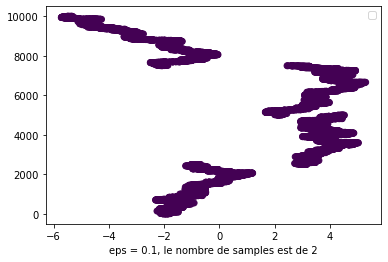

Le temps d'exécution est de : 0.3080461025238037
[-1 -1 -1 ... -1 -1 -1]


ValueError: Expected 2D array, got scalar array instead:
array=DBSCAN(eps=0.1, min_samples=2).
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

In [177]:
#KMEANS

#plot_clusters_kmeans_inertia(mystery_data4)
#plot_clusters_kmeans3D(mystery_data3)

#AGGLO

#plot_agglomerative(mystery_data4)

#DBSCAN

#plot_dbscan(data7, 0.3, 5)
plot_dbscan_iteration(mystery_data4)
#plot_dbscan(mystery_data5, 10)

DATAM1 : Kmeans

DATAM2 : Kmeans

DATAM3 : Kmeans

DATAM4 : Agglomerative